# Analysis of Grokking on MNIST with a CNN

In [155]:
# Imports
import os
import datetime
import random
import glob
import math
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from notebook import notebookapp
import datetime

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset

try:
    from torchmetrics import ConfusionMatrix
except:
    !pip install torchmetrics
    from torchmetrics import ConfusionMatrix

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# Scikit-learn
from sklearn.model_selection import train_test_split

# Set seeds for reproducability
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Step 1: Create dataset

In [157]:
# Datasets
dataset = torchvision.datasets.MNIST(root='./data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)


def get_datasets(train_size=100, val_size=10, device='cpu'):
    """
    - train_frac: What fraction of the total amount of data should be train versus validation
    - number_occurence: Number of occurences for each number 0-9 in the total data
    """

    targets = dataset.targets.numpy()
    
    # Allocate memory for data subset
    train_idx = np.zeros((10, train_size))
    val_idx = np.zeros((10, val_size))
    
    # Loop over all 10 numbers in dataset
    for number in range(10):
        number_idx = np.where(targets==number)[0]
        random_selection = np.random.choice(number_idx, train_size + val_size, replace=False)
        
        mask = np.zeros(random_selection.size)
        mask[np.random.choice(np.arange(mask.size), train_size, replace=False)] = 1
        train_idx[number] = random_selection[mask.astype(bool)]
        val_idx[number] = random_selection[~mask.astype(bool)]
    
    train_idx = train_idx.flatten().astype(int)
    np.random.shuffle(train_idx)
    val_idx = val_idx.flatten().astype(int)
    np.random.shuffle(val_idx)
        
    # Use indices to retrieve train/val split
    X_train = dataset.data[train_idx][:, None, :, :].double().to(device)
    Y_train = dataset.targets[train_idx].long().to(device)
    X_val = dataset.data[val_idx][:, None, :, :].double().to(device)
    Y_val = dataset.targets[val_idx].long().to(device)
    return X_train, Y_train, X_val, Y_val

# Step 2: Define model

In [159]:
# Default network architecture
img_size = 28
n_channels = 1
num_classes = 10

# Conv layers
num_filters = np.array([8, 16])
filter_sizes = np.array([5, 5])
pool_sizes = np.array([2, 2])

# Fully connected layer
fc_layers = np.array([64, 32])


class NumberDetector(nn.Module):
    def __init__(self, device='cpu', init_weight_factor=1):
        super(NumberDetector, self).__init__()
        self.device = device
        
        # For convolution
        self.conv1 = nn.Conv2d(n_channels, num_filters[0], kernel_size=filter_sizes[0], padding=filter_sizes[0]//2)
        self.conv2 = nn.Conv2d(num_filters[0], num_filters[1], kernel_size=filter_sizes[1], padding=filter_sizes[1]//2)
        
        self.pool1 = nn.MaxPool2d(kernel_size=(pool_sizes[0], pool_sizes[0]))
        self.pool2 = nn.MaxPool2d(kernel_size=(pool_sizes[1], pool_sizes[1]))
        
        self.relu = nn.ReLU()
        
        # For linear layers
        self.lin_input_size = int(num_filters[-1] * ( img_size / np.prod(pool_sizes) )**2)
        self.lin1 = nn.Linear(self.lin_input_size, fc_layers[0])
        self.lin2 = nn.Linear(fc_layers[0], fc_layers[1])
        
        # General stuff
        self.param_layers = [self.conv1, self.conv2, self.lin1, self.lin2]
        self.init_weights(init_weight_factor)

    
    # Calculate average weight norm of the model
    def get_weight_norm(self):
        weights = []
        
        for layer in self.param_layers:
            w = layer.weight.data.cpu().numpy()
            n = w.size
            avg = np.average(np.abs(w.flatten()))
            weights.append((n, avg))
           
        n_weights = 0
        avg_sum = 0
        
        for (n, avg) in weights:
            n_weights += n
            avg_sum += avg
            
        return avg_sum / n_weights

        
    # Multiply initial weights by a factor $init_weight_factor
    def init_weights(self, init_weight_factor):
        with torch.no_grad():
            for layer in self.param_layers:
                layer.weight.data = layer.weight.data * init_weight_factor

            
    def forward(self, x):
        # Conv layer 1
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        a1 = self.relu(p1)
        
        # Conv layer 2
        c2 = self.conv2(a1)
        p2 = self.pool2(c2)
        a2 = self.relu(p2)
        
        # Lin layer 1
        l1 = self.lin1(a2.view(-1, self.lin_input_size))
        a3 = self.relu(l1)
        
        # Lin layer 2
        out = self.lin2(a3)

        return out, c1, c2

# Step 3: Training the model

In [160]:
# Label specific analysis (precision, recall, conf matrix etc)
def number_analysis(predictions, labels, num_labels=10):
    predicted_labels = np.argmax(predictions.cpu().detach().numpy(), axis=1)
    loss_fn = torch.nn.CrossEntropyLoss()
    
    precision_loss = np.zeros(num_labels)
    recall_loss = np.zeros(num_labels)
    conf_mat = np.zeros((num_labels, num_labels))
    
    for actual_number in range(num_labels):
        precision_idx = np.where(predicted_labels == actual_number)[0]
        recall_idx = np.where(labels.cpu().numpy() == actual_number)[0]
        
        if precision_idx.size:
            precision_loss[actual_number] = loss_fn(predictions[precision_idx], labels[precision_idx])
        
        if recall_idx.size:
            recall_loss[actual_number] = loss_fn(predictions[recall_idx], labels[recall_idx])
            
        # Confusion matrix
        for predicted_number in range(num_labels):
            conf_mat[actual_number, predicted_number] = np.sum(predicted_labels[recall_idx] == predicted_number)
        
    return precision_loss, recall_loss, conf_mat


# Kernel exclusion analysis. What happens to performance if individual kernels are shut off?
def kernel_analysis(kernel_info, epoch, data, label, model, loss_fn):    
    layer_count = 0
    for layer in model.param_layers:
        if isinstance(layer, nn.Conv2d):
            for i in range(len(layer._parameters['weight'])):
                kernel_id = f"layer{layer_count}_kernel{i}"

                with torch.no_grad():
                    # Zero out weights
                    layer_backup = layer._parameters['weight'][i].clone().detach()
                    layer._parameters['weight'][i] = torch.DoubleTensor(np.zeros((1, 1, 5, 5)))
                    
                    # Calculate exclussion loss
                    pred = model(data)[0]
                    ex_loss = loss_fn(pred, label).item()
                    
                    # Do per-label analysis
                    if do_kernel_label_analysis:
                        precision_loss, recall_loss, confmat = number_analysis(pred, label)
                    else:
                        precision_loss, recall_loss, confmat = None, None, None
                    
                    # Reset weights
                    layer._parameters['weight'][i] = layer_backup
                    
                    # Calculate norm
                    norm = np.linalg.norm(layer_backup.cpu().numpy())
                    
                    
                    if kernel_id not in kernel_info.keys():
                        kernel_info[kernel_id] = {
                            'layer': layer_count,
                            'kernel': i,
                            'ex_loss': [ex_loss],
                            'weight_norm': [norm], 
                            'epoch': [epoch],
                            # Add kernel/label combination analysis
                            'precision_loss': [precision_loss],
                            'recall_loss': [recall_loss],
                            'confmat': [confmat]
                        }
                    else:
                        kernel_info[kernel_id]['ex_loss'].append(ex_loss)
                        kernel_info[kernel_id]['weight_norm'].append(norm)
                        kernel_info[kernel_id]['epoch'].append(epoch)
                        kernel_info[kernel_id]['precision_loss'].append(precision_loss)
                        kernel_info[kernel_id]['recall_loss'].append(recall_loss)
                        kernel_info[kernel_id]['confmat'].append(confmat)
            
            layer_count += 1

In [161]:
def train(run_name=datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")):
    # Random seeds for reproducability
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Init model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = NumberDetector(device=device, init_weight_factor=init_weight_factor).double()
    model.to(device)

    # Define optimizing process
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.98))
    loss_fn = torch.nn.CrossEntropyLoss()

    # Run formalities
    try:
        os.mkdir(save_root/run_name)
    except:
        print("Path already exists")
        
    save_dict = {'model':model.state_dict()}
    torch.save(save_dict, save_root/run_name/'init.pth')

    # Get data
    X_train, Y_train, X_val, Y_val = get_datasets(train_size, val_size, device=device)
    
    ###### Allocate space for in-training analysis
    # For regular loss and accuracy
    train_losses = np.zeros(num_epochs)
    val_losses = np.zeros(num_epochs)
    
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    
    weight_norms = np.zeros(num_epochs)
    weight_norms = np.zeros(num_epochs)
    
    # For label analysis
    train_precision_loss = np.zeros((10, num_epochs))
    val_precision_loss = np.zeros((10, num_epochs))
    
    train_recall_loss = np.zeros((10, num_epochs))
    val_recall_loss = np.zeros((10, num_epochs))
    
    train_confmat = np.zeros((10, 10, num_epochs)) 
    val_confmat = np.zeros((10, 10, num_epochs)) 
    
    # For kernel analysis
    kernel_info_train = {}
    kernel_info_val = {}
    
    
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Calculate train and val loss
        train_pred = model(X_train)[0]
        train_loss = loss_fn(train_pred, Y_train.to(device))
        train_losses[epoch] = train_loss.item()
        
        optimizer.zero_grad()
        train_loss.backward()
                
        val_pred = model(X_val)[0]
        val_loss = loss_fn(val_pred, Y_val.to(device))
        val_losses[epoch] = val_loss.item()
        
        # Accuracy
        train_acc[epoch] = (np.argmax(train_pred.cpu().detach().numpy(), axis=1) == Y_train.cpu().numpy()).sum() / Y_train.size()
        val_acc[epoch] = (np.argmax(val_pred.cpu().detach().numpy(), axis=1) == Y_val.cpu().numpy()).sum() / Y_val.size()
    
        # Label analysis
        if do_number_analysis:
            train_precision_loss[:, epoch], train_recall_loss[:, epoch], train_confmat[:, :, epoch] = number_analysis(train_pred, Y_train)
            val_precision_loss[:, epoch], val_recall_loss[:, epoch], val_confmat[:, :, epoch] = number_analysis(val_pred, Y_val)
        
        # Kernel analysis
        if do_kernel_analysis and (epoch%do_kernel_analysis_every == 0):
            with torch.no_grad():
                kernel_analysis(kernel_info_train, epoch, X_train, Y_train, model, loss_fn)
                kernel_analysis(kernel_info_val, epoch, X_val, Y_val, model, loss_fn)
        
        # Weight norm analysis
        if calc_weight_norms:
            weight_norms[epoch] = model.get_weight_norm()
    

        # Step with optimizer after all calculations
        if gradient_clip:
            torch.nn.utils.clip_grad_value_(model.parameters(), gradient_thresh) #, norm_type=2.0)
        optimizer.step()

        
        # Print status
        if epoch%100 == 0: 
            print(f"Epoch: {epoch} \t Train acc: {train_acc[epoch]:.4f} \t Val acc: {val_acc[epoch]:.4f} \t Train loss: {np.log(train_loss.item()):.4f} \t Val loss: {np.log(val_loss.item()):.4f}")
        
        # Save models
        if (save_models) and (epoch%save_every == 0):
            save_dict = {
                'model': model.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'epoch': epoch,
            }
            torch.save(save_dict, save_root/run_name/f"{epoch}.pth")
            print(f"Saved model to {save_root/run_name/f'{epoch}.pth'}")

    save_dict = {
        'model': model.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'train_precision_loss': train_precision_loss,
        'val_precision_loss': val_precision_loss,
        'train_recall_loss': train_recall_loss,
        'val_recall_loss': val_recall_loss,
        'train_confmat': train_confmat,
        'val_confmat': val_confmat,
        'weight_norms': weight_norms,
        'kernel_info_train': kernel_info_train,
        'kernel_info_val': kernel_info_val,
        'epoch': epoch,
    }

    torch.save(save_dict, save_root/run_name/f"final.pth")
    print(f"Saved model to {save_root/run_name/f'final.pth'}")

# Step 4: Run experiments

In [153]:
# Model params
lr=1e-3
gradient_clip = False
gradient_thresh = 1e-4

# Training params
num_epochs = 7000
save_root = Path("checkpoints")
val_size = 100

# What to save and calculate
save_models = False
save_every = 1000
do_kernel_analysis = False
do_kernel_analysis_every = 10
do_number_analysis = False
calc_weight_norms = True
do_kernel_label_analysis = False


# Define parameter choices
train_sizes = [5, 25]
weight_decays = [1.0]
weight_factors = [10]
tag = "demo"

# Loop over all parameters and run experiments
for size in train_sizes:
    train_size = size
    for decay in weight_decays:
        weight_decay = decay
        for factor in weight_factors:
            init_weight_factor = factor
        
            exp_name = f"{tag}_{decay}decay_{size}examples_{factor}factor"
            train(exp_name)

Path already exists
Epoch: 0 	 Train acc: 0.0 	 Val acc: 0.0 	 Train loss: 1.2436 	 Val loss: 1.2436
Epoch: 100 	 Train acc: 0.92 	 Val acc: 0.784 	 Train loss: -1.6057 	 Val loss: 0.1805
Epoch: 200 	 Train acc: 0.988 	 Val acc: 0.774 	 Train loss: -3.6389 	 Val loss: 0.9186
Epoch: 300 	 Train acc: 0.988 	 Val acc: 0.783 	 Train loss: -2.5452 	 Val loss: 0.9182
Epoch: 400 	 Train acc: 0.976 	 Val acc: 0.794 	 Train loss: -2.9686 	 Val loss: 1.2401
Epoch: 500 	 Train acc: 1.0 	 Val acc: 0.8 	 Train loss: -8.1568 	 Val loss: 1.1960
Epoch: 600 	 Train acc: 0.996 	 Val acc: 0.81 	 Train loss: -5.1889 	 Val loss: 1.1080
Epoch: 700 	 Train acc: 1.0 	 Val acc: 0.816 	 Train loss: -13.2028 	 Val loss: 1.1543
Epoch: 800 	 Train acc: 1.0 	 Val acc: 0.829 	 Train loss: -14.2296 	 Val loss: 0.9391
Epoch: 900 	 Train acc: 1.0 	 Val acc: 0.828 	 Train loss: -14.9237 	 Val loss: 0.9176
Epoch: 1000 	 Train acc: 1.0 	 Val acc: 0.832 	 Train loss: -15.8258 	 Val loss: 0.9430
Epoch: 1100 	 Train acc: 1.0

# Analysis
## Effect of training size

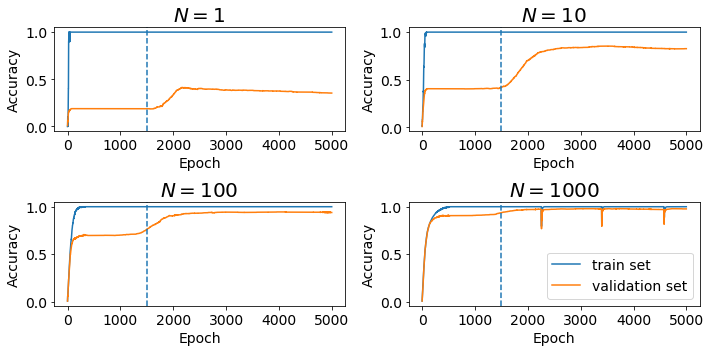

In [15]:
train_sizes = [1, 10, 100, 1000]
decay = 1.0
factor = 10
tag = "size_analysis"

axline=1500

n_cols = 2
fig, axs = plt.subplots(len(train_sizes) // n_cols, n_cols, figsize=(10, 5))
axs = axs.flatten()

for i, size in enumerate(train_sizes):
    exp_name = f"{tag}_{decay}decay_{size}examples_{factor}factor"
    load_dict = torch.load(f"checkpoints/{exp_name}/final.pth")

    axs[i].plot(load_dict['train_acc'], label='train set')
    axs[i].plot(load_dict['val_acc'], label="validation set")

    axs[i].set_title(f"$N={size}$", size=20)
    axs[i].set_xlabel("Epoch", size=14)
    axs[i].set_ylabel("Accuracy", size=14)
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    
    if axline:
        axs[i].axvline(axline, ls='dashed')#, label=f'Epoch={axline}')

axs[len(train_sizes)-1].legend(prop={'size': 14})

plt.tight_layout()
plt.savefig("numbers_training_size.svg")
plt.savefig("numbers_training_size.png")

## Effect of weight decay

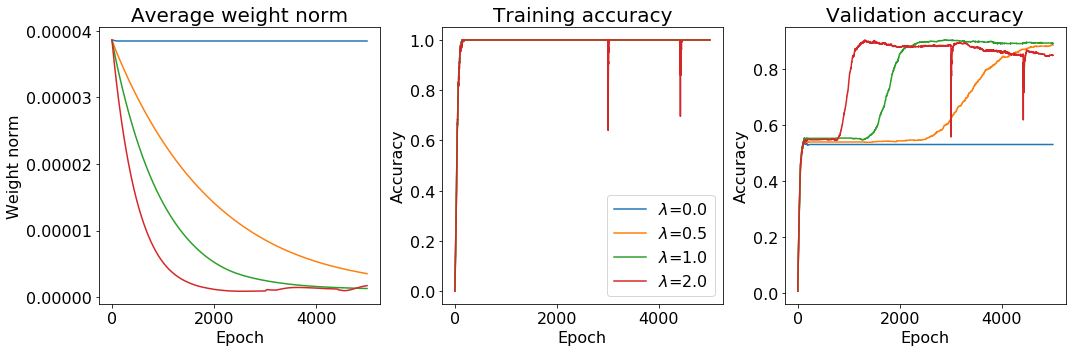

In [147]:
weight_decays = [0.0, 0.5, 1.0, 2.0]
size = 25
factor = 10
tag = "decay_analysis"


fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for decay in weight_decays:
    exp_name = f"{tag}_{decay}decay_{size}examples_{factor}factor"
    load_dict = torch.load(f"checkpoints/{exp_name}/final.pth")
    
    axs[0].plot(load_dict['weight_norms'], label=f"$\lambda$={decay}")
    axs[1].plot(load_dict['train_acc'], label=f"$\lambda$={decay}")
    axs[2].plot(load_dict['val_acc'], label=f"$\lambda$={decay}")
    

    
axs[0].tick_params(axis='both', which='major', labelsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=16)
axs[2].tick_params(axis='both', which='major', labelsize=16)

axs[0].set_ylabel("Weight norm", size=16)
axs[1].set_ylabel("Accuracy", size=16)
axs[2].set_ylabel("Accuracy", size=16)


axs[0].set_xlabel("Epoch", size=16)
axs[1].set_xlabel("Epoch", size=16)
axs[2].set_xlabel("Epoch", size=16)

axs[0].set_title("Average weight norm", size=20)
axs[1].set_title("Training accuracy", size=20)
axs[2].set_title("Validation accuracy", size=20)
    
axs[1].legend(prop={'size': 16})


plt.tight_layout()
plt.savefig("numbers_decay.png") 
plt.savefig("numbers_decay.svg") 

## Effect of init parameter

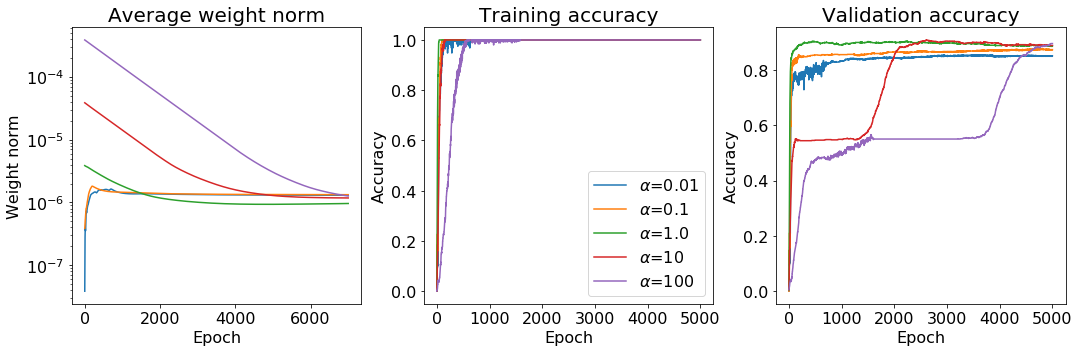

In [154]:
weight_factors = [0.01, 0.1, 1.0, 10, 100]
size = 25
decay = 1.0

tag = "init_analysis"


fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for factor in weight_factors:
    exp_name = f"{tag}_{decay}decay_{size}examples_{factor}factor"
    load_dict = torch.load(f"checkpoints/{exp_name}/final.pth")
    
    axs[0].plot(load_dict['weight_norms'][:7000], label=f"$α$={factor}")
    axs[1].plot(load_dict['train_acc'][:5000], label=f"$α$={factor}")
    axs[2].plot(load_dict['val_acc'][:5000], label=f"$α$={factor}")
    

    
axs[0].tick_params(axis='both', which='major', labelsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=16)
axs[2].tick_params(axis='both', which='major', labelsize=16)

axs[0].set_ylabel("Weight norm", size=16)
axs[1].set_ylabel("Accuracy", size=16)
axs[2].set_ylabel("Accuracy", size=16)

axs[0].set_xlabel("Epoch", size=16)
axs[1].set_xlabel("Epoch", size=16)
axs[2].set_xlabel("Epoch", size=16)

axs[0].set_title("Average weight norm", size=20)
axs[1].set_title("Training accuracy", size=20)
axs[2].set_title("Validation accuracy", size=20)
    
axs[1].legend(prop={'size': 16})

# Make things clear on plots by adjusting limits and scales
axs[0].set_yscale('log')


plt.tight_layout()
plt.savefig("numbers_init_factor.png") 
plt.savefig("numbers_init_factor.svg") 

## Visualize per-number performance

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


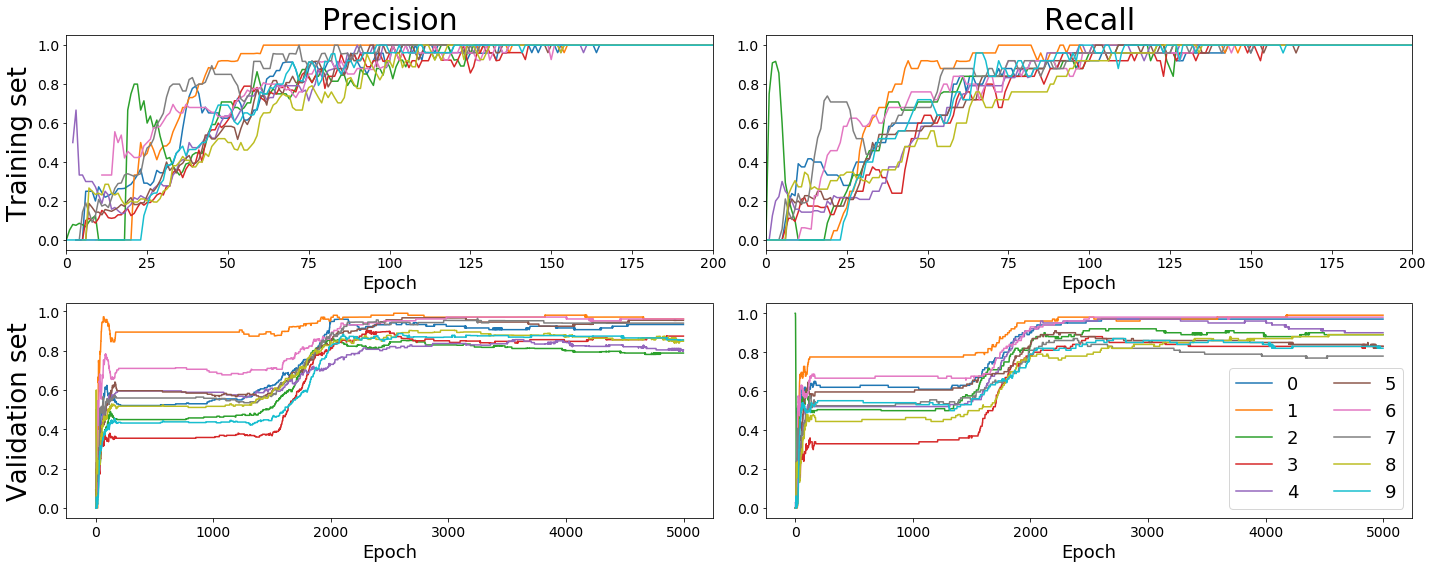

In [1067]:
factor = 10
size = 25
decay = 1.0
tag = "label_analysis"

f1 = False
train = True

exp_name = f"{tag}_{decay}decay_{size}examples_{factor}factor"
load_dict = torch.load(f"checkpoints/{exp_name}/final.pth")

n_cols = 3 if f1 else 2
n_rows = 2 if train else 1
fig, ax = plt.subplots(n_rows, n_cols,  figsize=(20, 8))
val_ax = ax[1] if train else ax
train_ax = ax[0] if train else None


# Load confusion matrices
val_confmat = load_dict['val_confmat']
val_label_counts = val_confmat.sum(axis=1)
val_num_preds = val_confmat.sum(axis=0)

if train:
    train_confmat = load_dict['train_confmat']
    train_label_counts = train_confmat.sum(axis=1)
    train_num_preds = train_confmat.sum(axis=0)

# For each label
for number in range(10):
    # Precision and recall    
    P_val = val_confmat[number, number, :]/val_num_preds[number, :]
    R_val = val_confmat[number, number, :]/val_label_counts[number, :]
    
    val_ax[0].plot(P_val, label=f"{number}")
    val_ax[1].plot(R_val, label=f"{number}")
    
    if f1:
        F1_val = 2*(P_val*R_val) / (P_val + R_val)
        val_ax[2].plot(F1_val, label=f"{number}")
    

    # Do the same for training scores
    if train:    
        P_train = train_confmat[number, number, :]/train_num_preds[number, :]
        R_train = train_confmat[number, number, :]/train_label_counts[number, :]
        
        train_ax[0].plot(P_train, label=f"{number}")
        train_ax[1].plot(R_train, label=f"{number}")
        
        
        if f1:
            F1_train = 2*(P_train*R_train) / (P_train + R_train)
            train_ax[2].plot(F1_train, label=f"{number}")
    
    

top_ax = ax[0] if train else ax
bot_ax = ax[1] if train else ax

top_ax[0].set_title("Precision", size=30)
top_ax[1].set_title("Recall", size=30)
bot_ax[0].set_xlabel("Epoch", size=18)
bot_ax[1].set_xlabel("Epoch", size=18)
top_ax[0].set_xlabel("Epoch", size=18)
top_ax[1].set_xlabel("Epoch", size=18)

if f1:
    top_ax[2].set_title("F1", size=18)
    bot_ax[2].set_xlabel("Epoch", size=14)

    
val_ax[0].set_ylabel("Validation set", size=26)

if train:
    train_ax[0].set_ylabel("Training set", size=26)

    a, b = 0, 200
    train_ax[0].set_xlim(a, b)
    train_ax[1].set_xlim(a, b)
    if f1:
        train_ax[2].set_xlim(a, b)


val_ax[1].legend(prop={'size': 18}, ncol=2)

for x in ax.flatten():
    x.tick_params(axis='both', which='major', labelsize=14)
    
plt.tight_layout()
plt.savefig("numbers_prec_rec.png")
plt.savefig("numbers_prec_rec.svg")

## Visualize confusion matrices

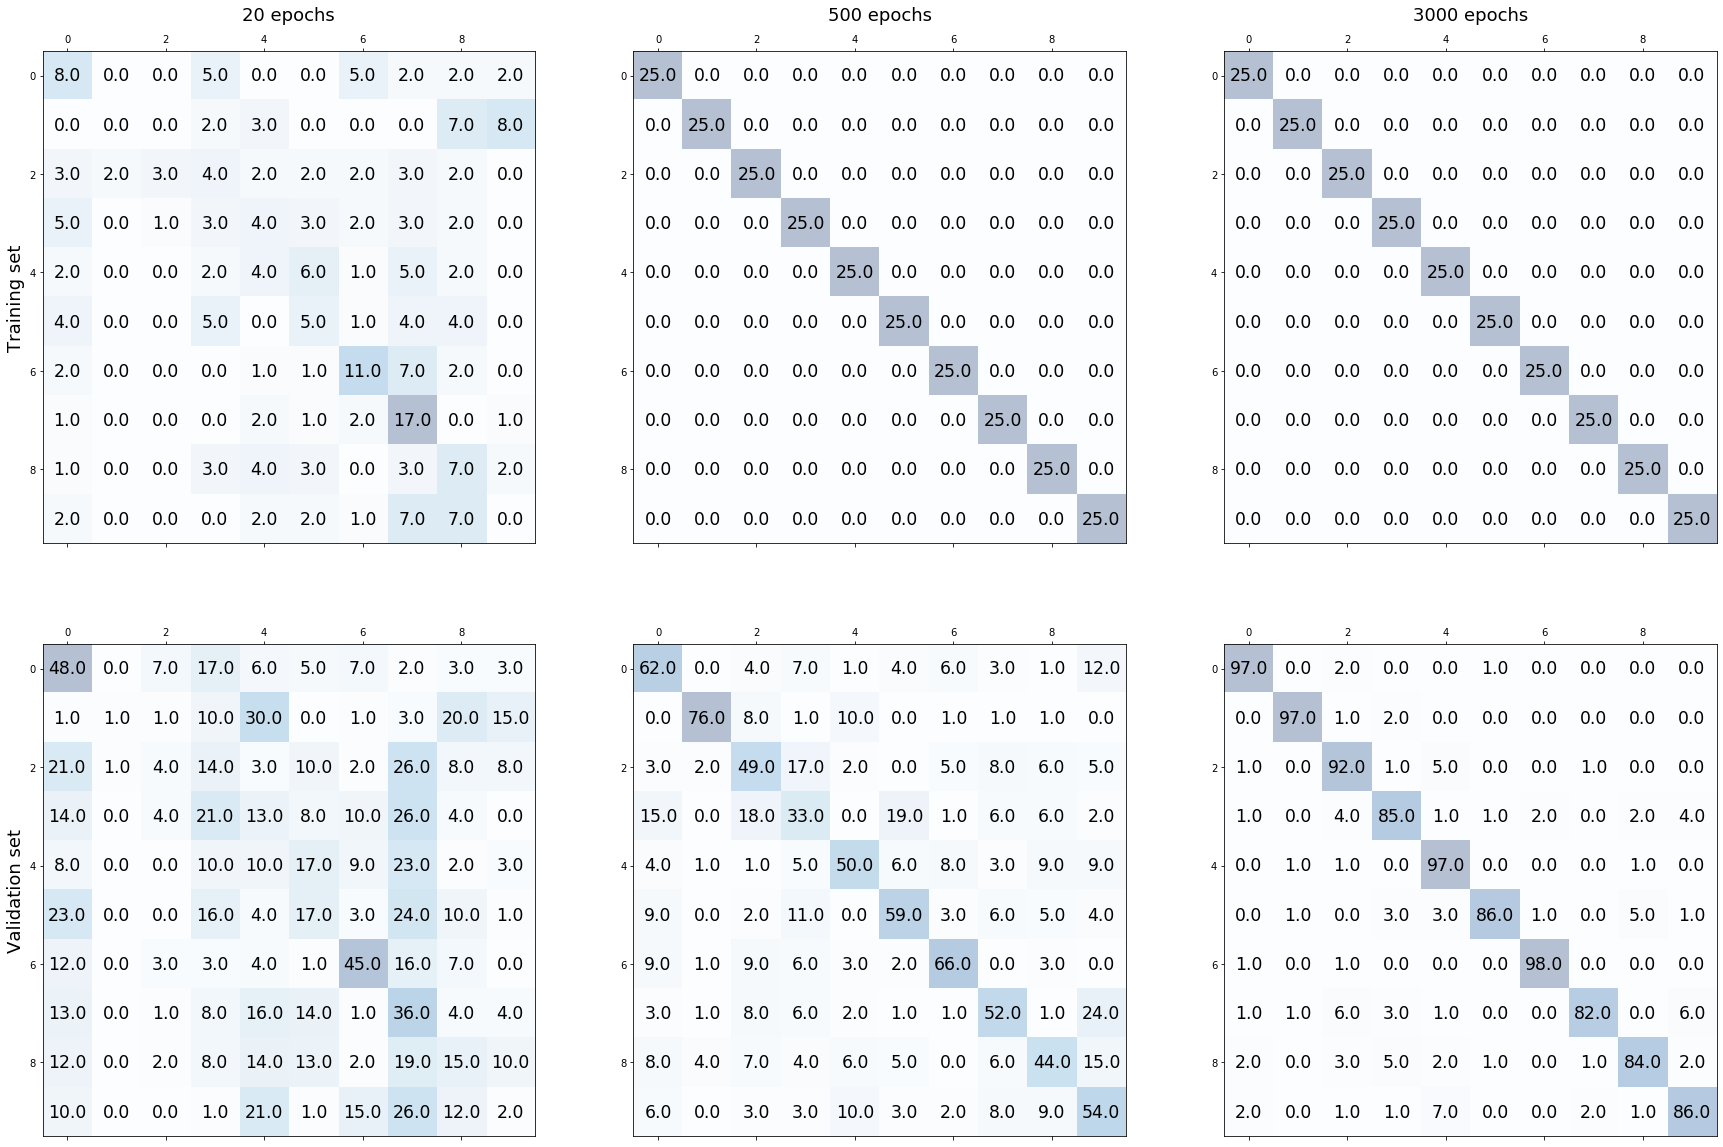

In [915]:
time_steps = [20, 500, 3000] 

factor = 10
size = 25
decay = 1.0
tag = "label_analysis"

exp_name = f"{tag}_{decay}decay_{size}examples_{factor}factor"
load_dict = torch.load(f"checkpoints/{exp_name}/final.pth")

train_confmat = load_dict['train_confmat']
val_confmat = load_dict['val_confmat']

fig, axs = plt.subplots(2, len(time_steps), figsize=(10*len(time_steps), 20))

for i, t in enumerate(time_steps):
    axs[0, i].set_title(f"{t} epochs", size=18)
    # Training set
    mat = train_confmat[:, :, t]
    ax = axs[0][i]
    
    ax.matshow(mat, cmap=plt.cm.Blues, alpha=0.3)
    for j in range(mat.shape[0]):
        for k in range(mat.shape[1]):
            ax.text(x=k, y=j,s=mat[j, k], va='center', ha='center', size='xx-large')
            
    # Validation
    mat = val_confmat[:, :, t]
    ax = axs[1][i]
    
    ax.matshow(mat, cmap=plt.cm.Blues, alpha=0.3)
    for j in range(mat.shape[0]):
        for k in range(mat.shape[1]):
            ax.text(x=k, y=j,s=mat[j, k], va='center', ha='center', size='xx-large')

axs[0, 0].set_ylabel("Training set", size=18)
axs[1, 0].set_ylabel("Validation set", size=18)
            
plt.savefig("numbers_conf_matrices.png")
plt.savefig("numbers_conf_matrices.svg")

# Exclussion analysis

## Vanilla exlcussion loss

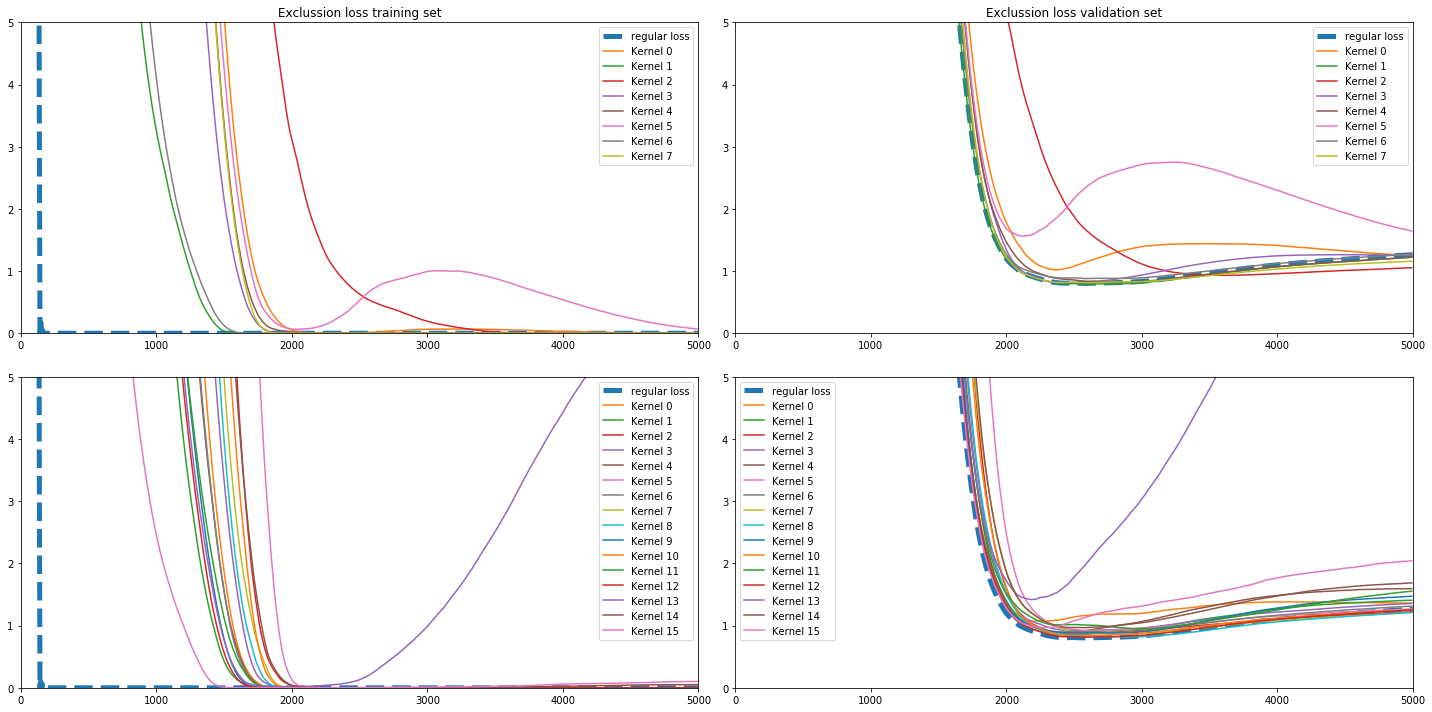

In [958]:
factor = 10
size = 25
decay = 1.0
tag = "label_analysis"

layers = [0, 1]  # What layers to visualize

train_int = (0, 5000)
val_int = (0, 5000)
y_int = (0, 5)


exp_name = f"{tag}_{decay}decay_{size}examples_{factor}factor"
load_dict = torch.load(f"checkpoints/{exp_name}/final.pth")

kernel_info_train = load_dict['kernel_info_train']
kernel_info_val = load_dict['kernel_info_val']
train_loss = load_dict['train_losses']
val_loss = load_dict['val_losses']


fig, axs = plt.subplots(len(layers), 2, figsize=(20, 5*len(layers)))

title_ax = axs[0] if len(layers) > 1 else axs
title_ax[0].set_title("Exclussion loss training set")
title_ax[1].set_title("Exclussion loss validation set")

for i, layer in enumerate(layers):
    layer_ax = axs[i] if len(layers) > 1 else axs
    
    layer_ax[0].plot(train_loss, label="regular loss", linewidth=5, linestyle="dashed")
    layer_ax[1].plot(val_loss, label="regular loss", linewidth=5, linestyle="dashed")
    
    for kernel_id, kernel_info in kernel_info_train.items():
        if kernel_info['layer'] == layer:
            layer_ax[0].plot(kernel_info['epoch'], kernel_info['ex_loss'], label=f"Kernel {kernel_info['kernel']}")
            
    for kernel_id, kernel_info in kernel_info_val.items():
        if kernel_info['layer'] == layer:
            layer_ax[1].plot(kernel_info['epoch'], kernel_info['ex_loss'], label=f"Kernel {kernel_info['kernel']}")
    
    
    layer_ax[0].set_xlim(train_int)
    layer_ax[0].set_ylim(y_int)
    layer_ax[1].set_xlim(val_int)
    layer_ax[1].set_ylim(y_int)
    
    layer_ax[0].legend()
    layer_ax[1].legend()
    
plt.tight_layout()
plt.savefig("numbers_exclussion_loss.png")
plt.savefig("numbers_exclussion_loss.svg")

## Relative ex loss

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide


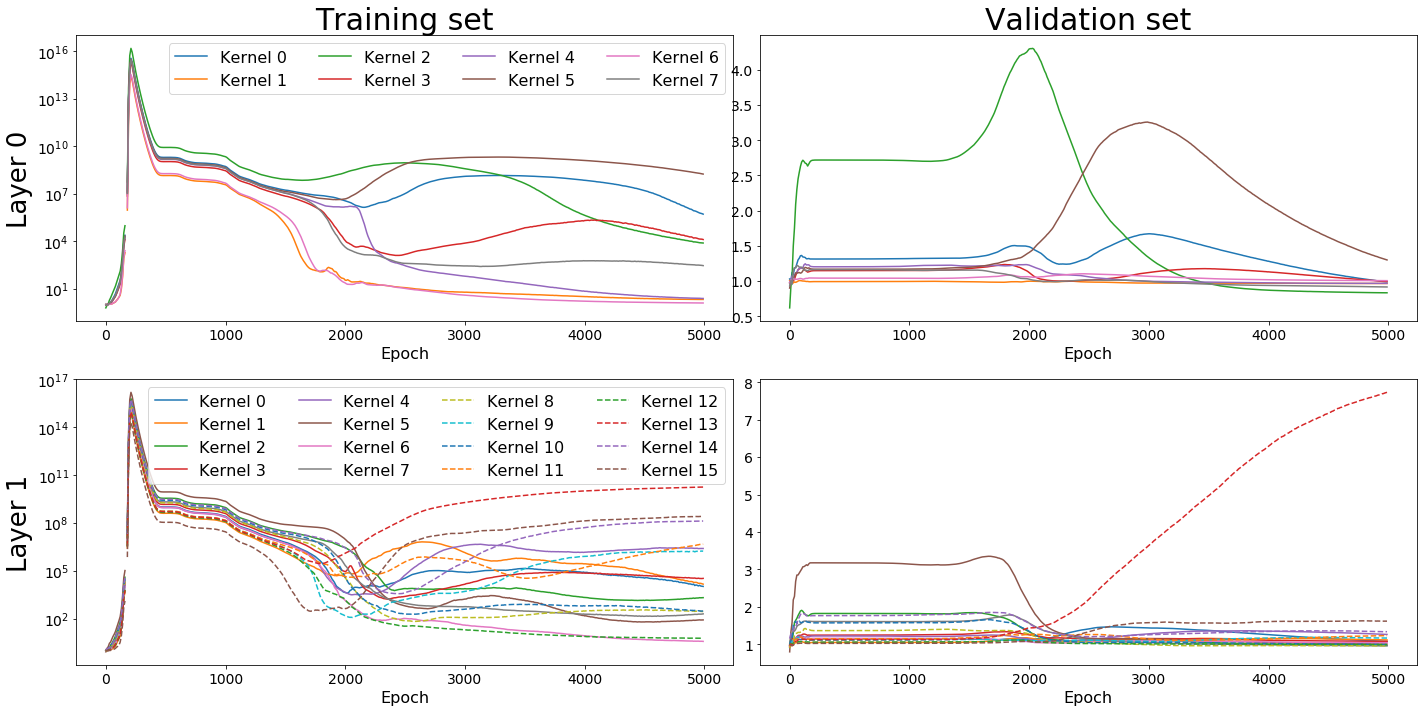

In [1071]:
factor = 10
size = 25
decay = 1.0
tag = "label_analysis"

layers = [0, 1]  # What layers to visualize
legend_cols = 4

train_int = (0, 5000)
val_int = (0, 5000)
y_int = (0, 5)


exp_name = f"{tag}_{decay}decay_{size}examples_{factor}factor"
load_dict = torch.load(f"checkpoints/{exp_name}/final.pth")

kernel_info_train = load_dict['kernel_info_train']
kernel_info_val = load_dict['kernel_info_val']
train_loss = load_dict['train_losses']
val_loss = load_dict['val_losses']


fig, axs = plt.subplots(len(layers), 2, figsize=(20, 5*len(layers)))

title_ax = axs[0] if len(layers) > 1 else axs
title_ax[0].set_title("Training set", size=30)
title_ax[1].set_title("Validation set", size=30)

for i, layer in enumerate(layers):
    layer_ax = axs[i] if len(layers) > 1 else axs
    
    count = 0
    for (kernel_id, kernel_info) in kernel_info_train.items():
        if kernel_info['layer'] == layer:
            relative_ex_loss = kernel_info['ex_loss'] / train_loss[kernel_info['epoch']]
            if count < 8:
                layer_ax[0].plot(kernel_info['epoch'], relative_ex_loss, label=f"Kernel {kernel_info['kernel']}")
            else:
                layer_ax[0].plot(kernel_info['epoch'], relative_ex_loss, label=f"Kernel {kernel_info['kernel']}", linestyle="dashed")
                
            count += 1
            
    count = 0
    for (kernel_id, kernel_info) in kernel_info_val.items():
        if kernel_info['layer'] == layer:
            relative_ex_loss = kernel_info['ex_loss'] / val_loss[kernel_info['epoch']]
            if count < 8:
                layer_ax[1].plot(kernel_info['epoch'], relative_ex_loss, label=f"Kernel {kernel_info['kernel']}")
            else:
                layer_ax[1].plot(kernel_info['epoch'], relative_ex_loss, label=f"Kernel {kernel_info['kernel']}", linestyle="dashed")
                
            count += 1
    
    layer_ax[0].set_yscale('log')
    #layer_ax[0].set_ylim(0, 100000)
    layer_ax[0].legend(ncol=legend_cols, prop={'size': 16})
    layer_ax[0].set_ylabel(f"Layer {i}", size=26)
    
    layer_ax[0].set_xlabel("Epoch", size=16)
    layer_ax[1].set_xlabel("Epoch", size=16)
    
    layer_ax[0].tick_params(axis='both', which='major', labelsize=14)
    layer_ax[1].tick_params(axis='both', which='major', labelsize=14)
    
    
    
plt.tight_layout()
plt.savefig("numbers_rel_ex_loss.png")
plt.savefig("numbers_rel_ex_loss.svg")

## Visualize kernels

### Visualize whole kernels

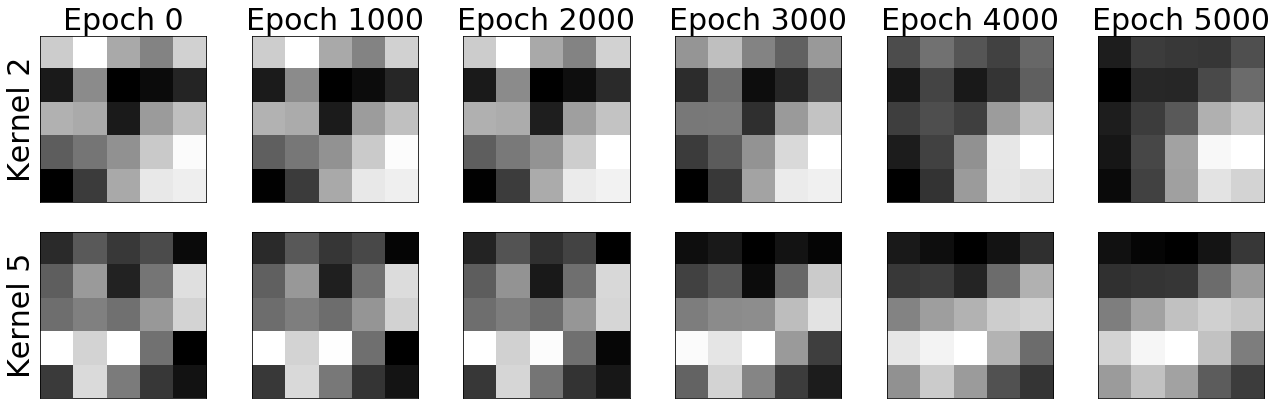

In [100]:
factor = 10
size = 25
decay = 1.0
tag = "label_analysis"

layer = 0
kernel_choice = [2, 5] # What layers to visualize
if not kernel_choice:
    kernel_choice = np.arange(8)
    

exp_name = f"{tag}_{decay}decay_{size}examples_{factor}factor"
cpts = glob.glob(f"checkpoints/{exp_name}/*")

kernels = {}
for cpt in cpts:
    if 'init' in cpt:
        epoch = 0
    elif 'final' in cpt:
        epoch = 5000
    else:
        epoch = int(os.path.basename(cpt).split(".")[0])

    load_dict = torch.load(cpt)
    kernels[epoch] = load_dict['model'][f'conv1.weight'][kernel_choice]

n_cols = len(list(kernels.items()))
n_rows = len(list(kernels.items())[0][1])
fig, axs = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))

for i, epoch in enumerate(sorted(kernels)):
    for j, kernel in enumerate(kernels[epoch].squeeze()):
        ax = axs[j][i] 

        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(kernel.cpu(), cmap='gray')

        if i == 0:
            ax.set_ylabel(f"Kernel {kernel_choice[j]}", size=30)
        if j == 0:
            ax.set_title(f"Epoch {epoch}", size=30)
            
plt.tight_layout()
plt.savefig("numbers_kernels.svg")

## Visualize activations from kernels

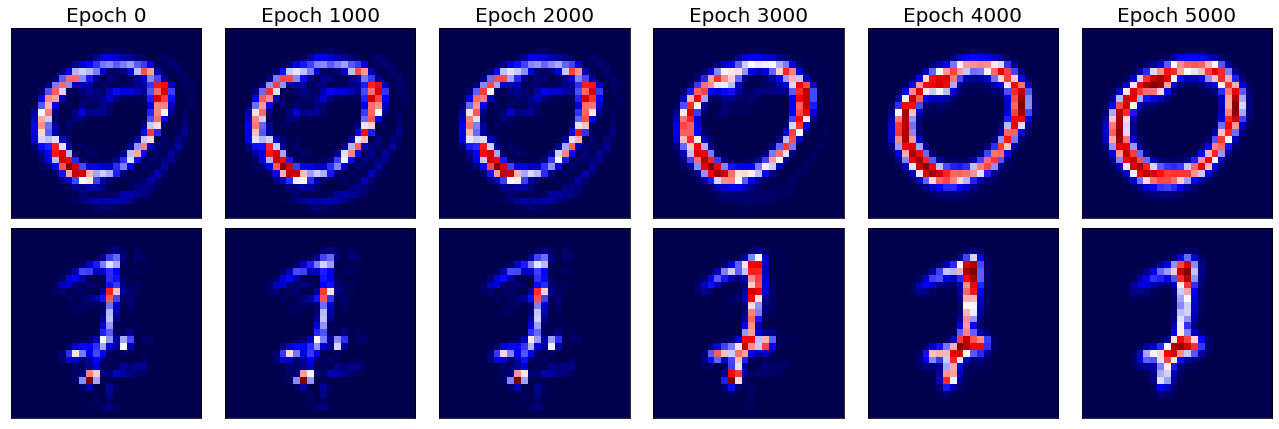

In [138]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

factor = 10
size = 25
decay = 1.0
tag = "label_analysis"

epochs = ['0', '1000', '2000', '3000', '4000', 'final']

kernel_choice = 2

number_choice = [0, 7]
if not number_choice:
    number_choice = np.arange(10)
    
# Matplotlib
fig, axs = plt.subplots(len(number_choice), len(epochs), figsize=(3*len(epochs), 3*len(number_choice)))


# Get 1 example of each number
X_train, Y_train, _, _ = get_datasets(train_size=1, device=device)
X_train = X_train[np.argsort(Y_train.cpu())]
X_train = X_train[number_choice]

for i, epoch in enumerate(epochs):    
    exp_name = f"{tag}_{decay}decay_{size}examples_{factor}factor"
    load_dict = torch.load(f"checkpoints/{exp_name}/{epoch}.pth")

    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = NumberDetector(device=device).double()
    model.to(device)
    model.load_state_dict(load_dict['model'])
    
    for j in range(len(X_train)):    
        activation = model(X_train[j].view(1, 1, 28, 28))[1].cpu().detach().numpy()
        activation = activation[:, kernel_choice].squeeze()
        
        a_min = activation.min()
        a_max = activation.max()

        # Plot image.
        number_ax = axs[j] if len(number_choice) > 1 else axs
        ax = number_ax[i] if len(epochs) > 1 else number_ax

        if j == 0:
            title = f"Epoch {epoch}" if epoch != 'final' else f"Epoch 5000"
            ax.set_title(title, size=20)

        ax.imshow(activation**2,# vmin=a_min, vmax=a_max,
                  interpolation='nearest', cmap='seismic')

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
plt.tight_layout()
plt.savefig(f"numbers_activation_kernel{kernel_choice}.svg")